In [1]:
import math
from itertools import combinations
import gurobipy as gp
from gurobipy import GRB, tupledict
import numpy as np
import matplotlib.pyplot as plt  

In [2]:
# pip install matplotlib

## Exercise 1: TSP

The Traveling Salesman Problem (TSP) is a problem where a salesman wants to visit all cities only once and return to the origin city with the least distance traveled.

In [3]:
# List of coordinates of 10 cities

cities = [(17, 72), (97, 8), (32, 15), (63, 97), (57, 60), (83, 48), (100, 26), (12, 62), (3, 49), (55, 77)]
n=len(cities)

In [4]:
# Dictionary of Euclidean distance between each pair of points

dist = {(i, j): math.sqrt(sum((cities[i][k]-cities[j][k])**2 for k in range(2)))
        for i in range(n) for j in range(i)}

In [5]:
# Plots a TSP solution

def figure_TSP(sol):
    ax = plt.gca() #get cuttent axis
    ax.cla() # clear things for fresh plot

    # change default range
    ax.set_xlim((0, 105))
    ax.set_ylim((0, 105))
    a = []
    b = []
    
    for i in sol:
        a = np.append(a, cities[i][1])
        b = np.append(b, cities[i][0])
    
    a = np.append(a, cities[sol[0]][1])
    b = np.append(b, cities[sol[0]][0]) 
    ax.plot(a,b)
    
    for i in sol:
        ax.plot(cities[i][1], cities[i][0], 'o',color = 'r')
        ax.text(cities[i][1], cities[i][0], str(i), color='black', fontsize=12)
    plt.show() 

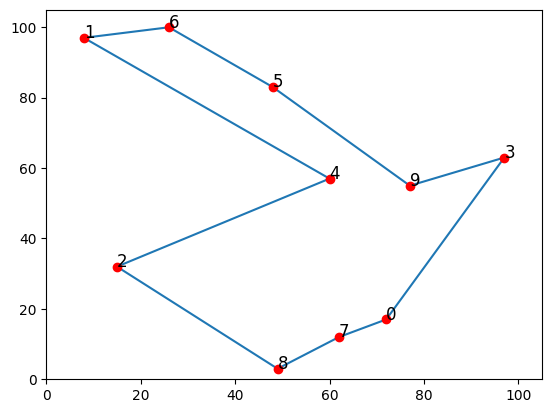

In [6]:
ex_opt_tour = [3, 0, 7, 8, 2, 4, 1, 6, 5, 9]
figure_TSP(ex_opt_tour)

Part 1: Model the full MILP

### 2 Index formulation of the TSP

\begin{align}
    Minimize & \sum_{i,j\in E}c_{i,j}x_{i,j}\\
    \textit{s.t.}&
    \sum_{i,j \in A | i < j } x_{i,j}=2 & \forall i \in N,\\
    &\sum_{i,j \in A | i,j \in S }x_{i,j} \leq |S|-1 & \forall S\subseteq N, 3 \leq |S|\\
    &\nonumber x_{ij} \in \{0,1\} & \forall (i,j)\in A.
\end{align}

Builds a tour from a solution with active edges

In [7]:
def build_tour_from_edges(edges):
    tour = []
    unvisited = list(range(n)) 
    start = 0
    neighbors = [j for i, j in edges.select(0, '*') if j in unvisited]
    while len(neighbors) >= 1:
        tour.append(neighbors[0])
        unvisited.remove(neighbors[0])
        neighbors = [j for i, j in edges.select(neighbors[0], '*') if j in unvisited]
    return tour

Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-19
(0, 1, 2)  constraints =  1
(0, 1, 3)  constraints =  2
(0, 1, 4)  constraints =  3
(0, 1, 5)  constraints =  4
(0, 1, 6)  constraints =  5
(0, 1, 7)  constraints =  6
(0, 1, 8)  constraints =  7
(0, 1, 9)  constraints =  8
(0, 2, 3)  constraints =  9
(0, 2, 4)  constraints =  10
(0, 2, 5)  constraints =  11
(0, 2, 6)  constraints =  12
(0, 2, 7)  constraints =  13
(0, 2, 8)  constraints =  14
(0, 2, 9)  constraints =  15
(0, 3, 4)  constraints =  16
(0, 3, 5)  constraints =  17
(0, 3, 6)  constraints =  18
(0, 3, 7)  constraints =  19
(0, 3, 8)  constraints =  20
(0, 3, 9)  constraints =  21
(0, 4, 5)  constraints =  22
(0, 4, 6)  constraints =  23
(0, 4, 7)  constraints =  24
(0, 4, 8)  constraints =  25
(0, 4, 9)  constraints =  26
(0, 5, 6)  constraints =  27
(0, 5, 7)  constraints =  28
(0, 5, 8)  constraints =  29
(0, 5, 9)  constraints =  30
(0, 6, 7)  constraints =  31
(0, 6, 8)  constrai

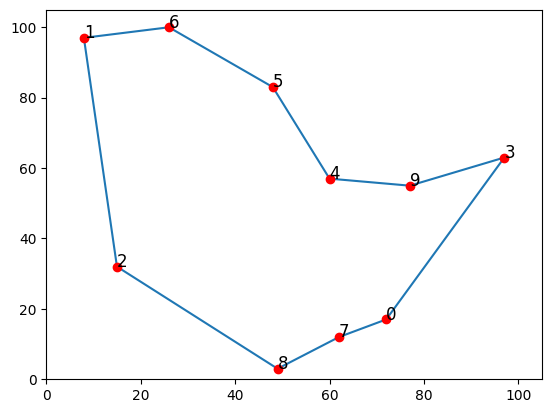

In [8]:
# Full model
m = gp.Model()

# Create variables
x = tupledict()
for i, j in dist.keys():
    x[i, j] = m.addVar(vtype=GRB.BINARY, name=f'x[{i},{j}]')
    x[j, i] = x[i, j]  # Edges both directions are the same 

# Add degree-2 constraints

m.addConstrs(x.sum(i, '*') == 2 for i in range(n))

# subtour constraints
count = 0
for tourlength in range(3, n):
    for subtour in combinations(range(n), tourlength):
        m.addConstr(gp.quicksum(x[i, j] for i, j in combinations(subtour, 2)) <= len(subtour)-1)
        count +=1
        print(subtour," constraints = ",count)

# set objective

objective = gp.quicksum(dist[i, j] * x[i, j] for i, j in dist.keys())
m.setObjective(objective, GRB.MINIMIZE)
m.setParam("OutputFlag", 1)

# Optimize model
m.optimize()

vals = m.getAttr('X', x)
edges = gp.tuplelist((i, j) for i, j in vals.keys() if vals[i, j] > 0.5)
tour = build_tour_from_edges(edges)

print('')
print(f'Optimal tour: {str(tour)}')
print(f'Optimal cost: {m.ObjVal}')
print('')

figure_TSP(tour)

## Number of constraints

\begin{align}
\Huge
\approx 2^n& \\
\Huge
&\Huge 2^{10} = 1024
\end{align}


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 21.6.0 21G651)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 13 rows, 45 columns and 120 nonzeros
Model fingerprint: 0x55afd8e5
Variable types: 0 continuous, 45 integer (45 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+01, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 6e+00]
Found heuristic solution: objective 566.5292943
Presolve time: 0.00s
Presolved: 13 rows, 45 columns, 120 nonzeros
Variable types: 0 continuous, 45 integer (45 binary)

Root relaxation: objective 3.027546e+02, 15 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     302.7546404  302.75464  0.00%     -    0s

Explored 1 nodes (15 simple

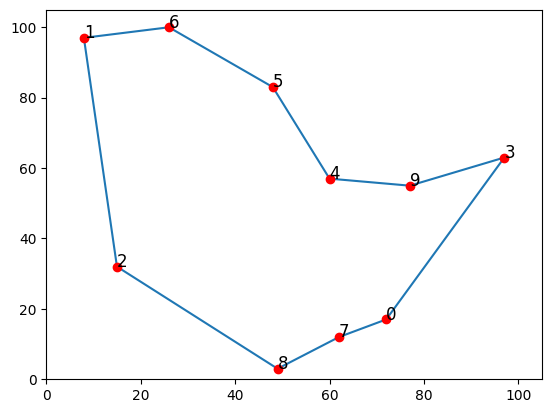

In [9]:
# Full model
m = gp.Model()

# Create variables
x = tupledict()
for i, j in dist.keys():
    x[i, j] = m.addVar(vtype=GRB.BINARY, name=f'x[{i},{j}]')
    x[j, i] = x[i, j]  # Edges both directions are the same 

# Add degree-2 constraints

m.addConstrs(x.sum(i, '*') == 2 for i in range(n))

# subtour constraints

subtour = [2, 7, 0, 8]
m.addConstr(gp.quicksum(x[i, j] for i, j in combinations(subtour, 2)) <= len(subtour)-1)

subtour = [7, 0, 8]
m.addConstr(gp.quicksum(x[i, j] for i, j in combinations(subtour, 2)) <= len(subtour)-1)

subtour = [3, 0, 7, 8, 2, 4, 9]
m.addConstr(gp.quicksum(x[i, j] for i, j in combinations(subtour, 2)) <= len(subtour)-1)


objective = gp.quicksum(dist[i, j] * x[i, j] for i, j in dist.keys())
m.setObjective(objective, GRB.MINIMIZE)
m.setParam("OutputFlag", 1)

# Optimize model

m.optimize()

vals = m.getAttr('X', x)
edges = gp.tuplelist((i, j) for i, j in vals.keys() if vals[i, j] > 0.5)
tour = build_tour_from_edges(edges)

print('')
print(f'Optimal tour: {str(tour)}')
print(f'Optimal cost: {m.ObjVal}')
print('')

figure_TSP(tour)

### Part 2: Write the subtour identification function

In [10]:
# Callback - use lazy constraints to eliminate sub-tours

def subtourelim(model, where):
    # if we find an integer solution
    if where == GRB.Callback.MIPSOL:
        # then read out the values
        vals = model.cbGetSolution(model._vars)
        print("Calling Callback")
        # find the shortest cycle in the solution
        tour = subtour(vals)
        print("Detected subtour = ", tour)
        # if the cycle is not the whole set, then add a cut to remove it
        if len(tour) < n:
            # add subtour elimination constr. for every pair of cities in tour
            model.cbLazy(gp.quicksum(model._vars[i, j] for i, j in combinations(tour, 2)) <= len(tour)-1)

In [11]:
example_vals = {(1, 0): 1.0, (0, 1): 1.0, (2, 0): 0.0, (0, 2): 0.0, (2, 1): 0.0, (1, 2): 0.0, (3, 0): 0.0, (0, 3): 0.0, (3, 1): 0.0, (1, 3): 0.0, (3, 2): 0.0, (2, 3): 0.0, (4, 0): 0.0, (0, 4): 0.0, (4, 1): 0.0, (1, 4): 0.0, (4, 2): 0.0, (2, 4): 0.0, (4, 3): 0.0, (3, 4): 0.0, (5, 0): 0.0, (0, 5): 0.0, (5, 1): 0.0, (1, 5): 0.0, (5, 2): 0.0, (2, 5): 0.0, (5, 3): 1.0, (3, 5): 1.0, (5, 4): 0.0, (4, 5): 0.0, (6, 0): 0.0, (0, 6): 0.0, (6, 1): 0.0, (1, 6): 0.0, (6, 2): 1.0, (2, 6): 1.0, (6, 3): 0.0, (3, 6): 0.0, (6, 4): 1.0, (4, 6): 1.0, (6, 5): 0.0, (5, 6): 0.0, (7, 0): 0.0, (0, 7): 0.0, (7, 1): 0.0, (1, 7): 0.0, (7, 2): 1.0, (2, 7): 1.0, (7, 3): 0.0, (3, 7): 0.0, (7, 4): 1.0, (4, 7): 1.0, (7, 5): 0.0, (5, 7): 0.0, (7, 6): 0.0, (6, 7): 0.0, (8, 0): 1.0, (0, 8): 1.0, (8, 1): 1.0, (1, 8): 1.0, (8, 2): 0.0, (2, 8): 0.0, (8, 3): 0.0, (3, 8): 0.0, (8, 4): 0.0, (4, 8): 0.0, (8, 5): 0.0, (5, 8): 0.0, (8, 6): 0.0, (6, 8): 0.0, (8, 7): 0.0, (7, 8): 0.0, (9, 0): 0.0, (0, 9): 0.0, (9, 1): 0.0, (1, 9): 0.0, (9, 2): 0.0, (2, 9): 0.0, (9, 3): 1.0, (3, 9): 1.0, (9, 4): 0.0, (4, 9): 0.0, (9, 5): 1.0, (5, 9): 1.0, (9, 6): 0.0, (6, 9): 0.0, (9, 7): 0.0, (7, 9): 0.0, (9, 8): 0.0, (8, 9): 0.0}

In [12]:
# Given a tuplelist of edges, find the shortest subtour
# input: dictionary of solution values for all edges
# output: List of nodes that build shortest cycle (ex. [0, 2, 4, 1])
def subtour(vals):
    # make a list of edges selected in the solution
    edges = gp.tuplelist((i, j) for i, j in vals.keys() if vals[i, j] > 0.5) # numercial safety
    unvisited = list(range(n))
    cycle = range(n+1)  # largest cycle has length n + 1
    while len(unvisited) >= 1: # while there are unvisited nodes
        thiscycle = [] # initialize empty cycle
        neighbors = unvisited # initialize "neighbours" to be everyone
        while len(neighbors) >= 1: # while there are neighbours left
            current = neighbors[0] # take first neighbour in list
            thiscycle.append(current) # add neighbour to cycle
            unvisited.remove(current) # remove neighbour from unvisited nodes
            neighbors = [j for i, j in edges.select(current, '*') if j in unvisited] 
            
            # define neighbours to be the nodes for which there is an edge from current node
            
            # basically as soon as we finish walking along edges and there are suddendly no 
            
            # neighbours left, it means we already visited all neighbours ==> cycle
            
            # with the degree 2 constraint, cycles are the only possible structure
        
        if len(thiscycle) < len(cycle):
            cycle = thiscycle
    return cycle

In [13]:
subtour(example_vals)

[0, 1, 8]

### Part 3: Code the model using lazy constraints

Set parameter LazyConstraints to value 1
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 21.6.0 21G651)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 10 rows, 45 columns and 90 nonzeros
Model fingerprint: 0xe143fde1
Variable types: 0 continuous, 45 integer (45 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+01, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Calling Callback
Detected subtour =  [0, 1, 8]
Presolve time: 0.00s
Presolved: 10 rows, 45 columns, 90 nonzeros
Variable types: 0 continuous, 45 integer (45 binary)
Calling Callback
Detected subtour =  [1, 5, 6]
Calling Callback
Detected subtour =  [0, 8, 1, 9]

Root relaxation: objective 3.018755e+02, 15 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent 

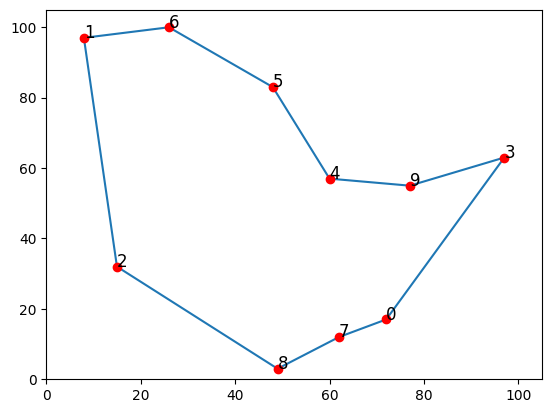

In [14]:
# Lazy constraints model
m = gp.Model()

# Create variables
x = tupledict()
for i, j in dist.keys():
    x[i, j] = m.addVar(vtype=GRB.BINARY, name=f'x[{i},{j}]')
    x[j, i] = x[i, j]  # edge in opposite direction

# Add degree-2 constraint
m.addConstrs(x.sum(i, '*') == 2 for i in range(n))


# set objective
objective = gp.quicksum(dist[i, j] * x[i, j] for i, j in dist.keys())
m.setObjective(objective, GRB.MINIMIZE)

# Optimize model
m._vars = x # store variables in model m._vars
m.Params.LazyConstraints = 1
m.optimize(subtourelim)

vals = m.getAttr('X', x)
edges = gp.tuplelist((i, j) for i, j in x.keys() if vals[i, j] > 0.5)
tour = build_tour_from_edges(edges)


print('')
print(f'Optimal tour: {str(tour)}')
print(f'Optimal cost: {m.ObjVal}')
print('')

figure_TSP(tour)

## Exercise 2: Extension to VRP

\begin{align*}
    Minimize & \sum_{i,j\in E}c_{i,j}x_{i,j}\\
    \textit{s.t.}&
    \sum_{i,j \in A | i < j } x_{i,j}=2 & \forall i \in V\setminus \{0\},\\
    &\sum_{i,j \in A | i,j \in S }x_{i,j} \leq |S|-\left \lceil\frac{\sum_{i\in S}q_i}{Q} \right \rceil & \forall S\subseteq N, S \neq \emptyset,\\
    &\nonumber x_{ij} \in \{0,1\} & \forall (i,j)\in A.
\end{align*}

In [15]:
Depot = (50,50) # Depot coordinates
cities = [(Depot)] #coordinates of all customers
Depot_id = 0 # Depot idendifier
cities += [(17, 72), (97, 8), (32, 15), (63, 97), (57, 60), (83, 48), (100, 26), (12, 62), (3, 49), (55, 77), 
          (97, 98), (0, 89), (57, 34), (92, 29), (75, 13), (40, 3), (2, 3), (83, 69), (1, 48), (87, 27), 
          (54, 92), (3, 67), (28, 97), (56, 63), (70, 29), (44, 29), (86, 28), (97, 58), (37, 2), (53, 71), 
          (82, 12), (23, 80), (92, 37), (15, 95), (42, 92), (91, 64), (54, 64), (85, 24), (38, 36), (75, 63), 
          (64, 50), (75, 4), (61, 31), (95, 51), (53, 85), (22, 46), (70, 89), (99, 86), (94, 47), (11, 56)]

n = len(cities)

# Dictionary of Euclidean distance between each pair of points
dist = {(i, j): math.sqrt(sum((cities[i][k]-cities[j][k])**2 for k in range(2))) for i in range(n) for j in range(i)}

# Capacity of vehicle
Q = 20
print(n)

51


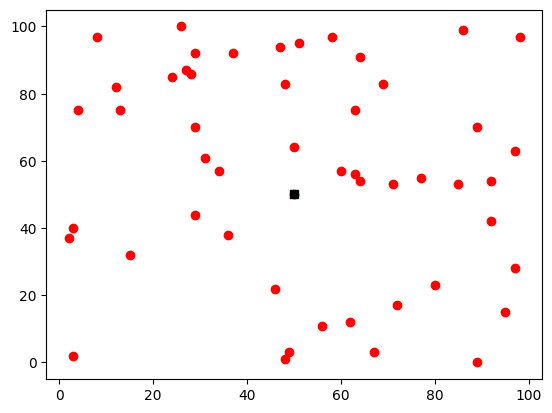

In [16]:
# Graph the input
x = [el[1] for el in cities]
y = [el[0] for el in cities]
plt.scatter(x, y,color = 'r')
ax = plt.gca()
ax.plot(cities[Depot_id][1],cities[Depot_id][0], 's', color = 'black')
plt.show()

## Giant tour representation of VRP
The depot is 0. Each time we return to the depot we add a 0 to the list

Example of giant tour = [0, 1, 2, 3, 4, 5, 0, 6, 7, 8, 0, 9, 10, 11, 12, 13, 14, 15, 0]

In [17]:
# Given a tuplelist of edges, build the full path of all vehicles, as one long path
def buildpath(vals):
    # first check if anything is connected to the depot at all
    unvisited = list(range(n)) 
    edges = gp.tuplelist((i, j) for i, j in vals.keys() if vals[i, j] > 0.5)
    neighbors = [j for i, j in edges.select(Depot_id, '*') if j in unvisited]
    path = []
    if len(neighbors) == 0: # if nothing is connected to the depot, return an empty list
        return path
    
    # if there are nodes connected to the depot:
    path.append(Depot_id) # add the depot to the path
    
    # build the long path
    while len(neighbors) >= 1:
        path.append(neighbors[-1])
        if neighbors[-1] != Depot_id:
            unvisited.remove(neighbors[-1])
        neighbors = [j for i, j in edges.select(path[-1], '*') if j in unvisited]
    return path

In [18]:
# plotting function for the solution

def figure_VRP(t):
    ax = plt.gca()
    ax.cla() # clear things for fresh plot

    # change default range so that new circles will work
    ax.set_xlim((-5, 105))
    ax.set_ylim((-5, 105))
    a = []
    b = []
    
    for i in t:
        #ax.plot(cities[i][1],cities[i][0], 'o',color = 'r')
        a = np.append(a, cities[i][1])
        b = np.append(b, cities[i][0])    
    a = np.append(a, cities[tour[0]][1])
    b = np.append(b, cities[tour[0]][0]) 
    ax.plot(a,b)
    for i in t:
        ax.plot(cities[i][1], cities[i][0], 'o',color = 'r')
        ax.text(cities[i][1], cities[i][0], str(i), color='black', fontsize=8)
    ax.plot(cities[Depot_id][1], cities[Depot_id][0], 's', color = 'black')

    plt.show() 

In [19]:
# Adjusted callback function

def subtourelim_VRP(model, where):
    if where == GRB.Callback.MIPSOL:
        vals = model.cbGetSolution(model._vars)
        subtour = subtourVRP(vals) # returns a subset that violates the constraints. 
        
        model.cbLazy(gp.quicksum(model._vars[i, j] for i, j in combinations(subtour, 2))\
                     <= len(subtour)-math.ceil(len(subtour)/Q))
        

In [20]:
# Given a tuplelist of edges, find the shortest subtour
# input: dictionary of solution values for all edges
# output: List of nodes that build shortest cycle (ex. [0, 2, 4, 1])
def subtourVRP(vals):
    
    # make a list of edges selected in the solution
    edges = gp.tuplelist((i, j) for i, j in vals.keys() if vals[i, j] > 0.75) # numercial safety
    unvisited = list(range(n))
    cycle = list(range(n))  # largest cycle has length n
    change = True
    while len(unvisited) >= 1 and change:
        thiscycle = []
        neighbors = [0]
        while len(neighbors) >= 1:
            change = True
            current = neighbors[0]
            thiscycle.append(current)
            if current in unvisited:
                unvisited.append(current)
            neighbors = [j for i,j in edges.select(current, '*') if j in unvisited]

            if current == Depot_id and len(neighbors) == 0:
                change = False

    if 0 in thiscycle:
        thiscycle.remove(0)
    if math.ceil(len(thiscycle)/Q) > 1:
        cycle = thiscycle
        return thiscycle
    return cycle

In [ ]:
m = gp.Model()

# Create variables
x = tupledict()
for i, j in dist.keys():
    x[i, j] = m.addVar(vtype=GRB.BINARY, name=f'x[{i},{j}]')
    x[j, i] = x[i, j]  # make your life easier by not having to worry about indexing order


# Add degree-2 constraint
for i in range(n):
    if i != Depot_id:
        m.addConstr(sum(x[i,j] for j in range(n) if i!=j) == 2)
        

# set objective
objective = gp.quicksum(dist[i, j] * x[i, j] for i, j in dist.keys())
m.setObjective(objective, GRB.MINIMIZE)


# Optimize model
m._vars = x
m.Params.LazyConstraints = 1
m.optimize(subtourelim_VRP)

vals = m.getAttr('X', x)
edges = gp.tuplelist((i, j) for i, j in vals.keys() if vals[i, j] > 0.5 if i < j)
tour = buildpath(vals)

figure_VRP(tour)

print("number of cities (with depot): ",  n)
print("Cities ", cities)
print('')
print('Optimal tour: %s' % str(tour))
print('Optimal cost: %g' % m.ObjVal)
print('')

Set parameter LazyConstraints to value 1
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 21.6.0 21G651)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 50 rows, 1275 columns and 2500 nonzeros
Model fingerprint: 0x1de508e0
Variable types: 0 continuous, 1275 integer (1275 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
